# **Addressing Mexico City's Water Crisis Proposing Strategic Solutions by Using Big Data Analytics**

## **Project Overview**
This project leverages big data analytics using PySpark and Amazon Web Services to tackle the ongoing water crisis in Mexico City (CDMX).  By processing and analyzing extensive water incident reports provided by the Sistema de Aguas de la Ciudad de México (SACMEX).

This proposal aims to develop a comprehensive data-driven strategy to address Mexico City's escalating water crisis. By integrating real-time analytics, it seeks to identify infrastructure vulnerabilities, pinpoint critical hotspots for immediate intervention, and enhance resource allocation. The end-to-end solution involves a robust ETL pipeline using PySpark for scalable data transformation and Amazon QuickSight for dynamic, actionable visualizations. The ultimate goal is to empower government authorities and policymakers with the insights needed to implement effective, sustainable solutions for water management.


#### **Motivation**
Mexico City, home to over 21 million residents, is grappling with an escalating water management challenge exacerbated by over-reliance on aquifers, aging infrastructure, and climate variability. Excessive groundwater extraction has led to severe land subsidence, damaging water distribution networks and increasing the risk of system failures. The Sistema de Aguas de la Ciudad de México (SACMEX), the city's water authority, faces immense pressure to modernize the water supply system, reduce leakages, and meet growing demand.

Recent studies highlight the severity of the situation:
* The World Bank estimates that up to 40% of the city’s water supply is lost through leaks due to outdated pipes (World Bank, 2021).
* NBC News emphasizes that Mexico City's 21 million residents face a severe water shortage, worsened by inefficient infrastructure and rising demand (NBC News, 2023).
This project aims to support SACMEX and more corresponding authorities in transforming their approach from reactive to strategic, using advanced analytics and big data techniques to identify high-risk areas, improve resource allocation, and drive sustainable water management policies.
* National Geographic reports subsidence rates of up to 50 centimeters per year in certain areas, threatening both infrastructure and water security (National Geographic, 2022).


#### **Data source**
The dataset used in this project is sourced from the open data portal of the Government of Mexico City (Datos CDMX), specifically the water incident reports managed by SACMEX. This dataset provides valuable insights into the operational challenges faced by the city’s water management system. Retrieved from
Datos CDMX, "Reportes de Agua," Sistema de Aguas de la Ciudad de México (SACMEX). Available at: https://datos.cdmx.gob.mx/dataset/reportes-de-agua

**Dataset Overview:**

Provider: Sistema de Aguas de la Ciudad de México (SACMEX)
Content:
- Incident Reports: Includes data on various water-related issues such as **"No Water"**, "Sewage Overflow," "Blocked Drain," and "Leak."
- Geospatial Information: Latitude and longitude data for precise mapping of incidents across different neighborhoods and boroughs.
- Temporal Data: Report date and time, allowing analysis of trends over time.
- Location Data: Borough and neighborhood information for granular analysis.
- Incident Descriptions: Detailed descriptions of the reported issues, allowing for categorization and impact assessment.

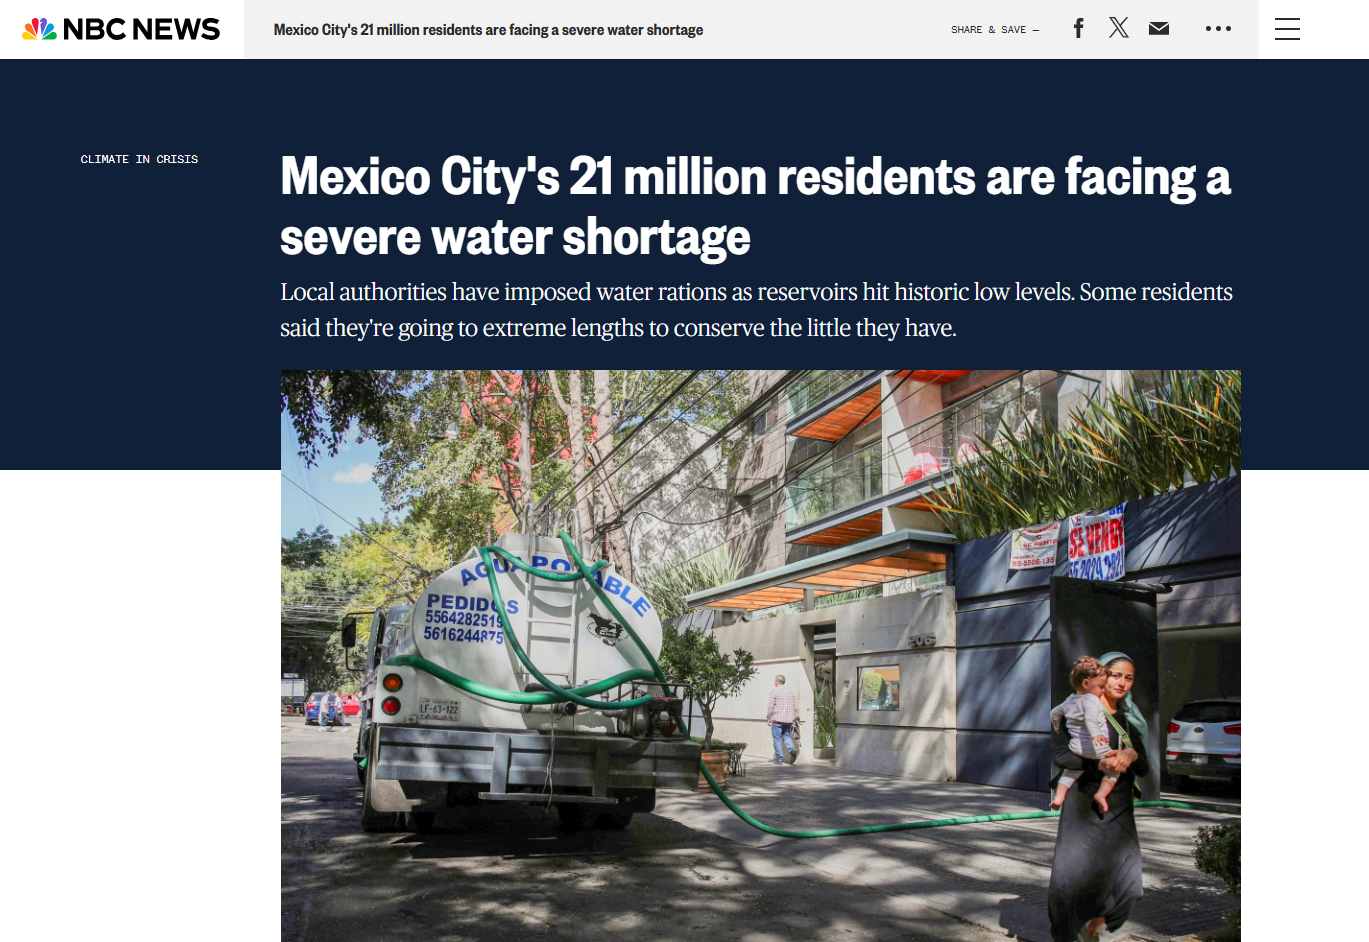

#### **References**
* National Geographic, "Mexico City’s Water Crisis: Earth Sinking as City Faces Growing Crisis." Available at: https://www.nationalgeographic.com/environment/article/mexico-city-water-crisis
* World Bank, "Mexico City’s Water Challenges: Infrastructure and Over-Extraction Issues." Available at: https://www.worldbank.org/mexico-city-water-challenges
* NBC News, "Mexico City’s 21 million residents are facing a severe water shortage." Available at: https://www.nbcnews.com/science/science-news/mexico-citys-21-million-residents-are-facing-severe-water-shortage-rcna140669


## Data Extraction
Raw data from SACMEX is ingested from the open data portal

In [ ]:
#Configuring our SparkSession
from pyspark.sql import SparkSession

#Create a SparkSession
spark = SparkSession.builder \
    .appName("water_reports_CDMX") \
    .getOrCreate()

In [ ]:
#df reading
df = spark.read.csv("reportes_agua_2024_01.csv", header=True, inferSchema=False)
#Print columns
print(f'Columns and data types: \n {df.schema}')


#Calculate the dataset dimensions
num_rows = df.count()
num_cols = len(df.columns)

#Print the dimensions
print(f"\nDataset Dimensions: {num_rows} rows x {num_cols} columns")


Columns and data types: 
 StructType([StructField('folio_incidente', StringType(), True), StructField('fecha_registro_incidente', StringType(), True), StructField('id_reporte', StringType(), True), StructField('fecha_reporte', StringType(), True), StructField('hora_reporte', StringType(), True), StructField('clasificacion', StringType(), True), StructField('reporte', StringType(), True), StructField('medio_recepcion', StringType(), True), StructField('alcaldia_catalogo', StringType(), True), StructField('colonia_catalogo', StringType(), True), StructField('longitud', StringType(), True), StructField('latitud', StringType(), True)])

Dataset Dimensions: 313756 rows x 12 columns


##  Data Wrangling Using PySpark
Data Cleaning:
Remove duplicates, handle missing values, and standardize column formats to ensure consistency and reliability.

Formatting and Standardization:
Dates and other time-based fields were reformatted for uniformity, and categorical values were standardized for proper analysis and visualization.

Feature Engineering:
Create additional features to enhance the dataset’s analytical depth and relevance.

New Features:
Relevant features were derived to capture key insights from the data, to better align with the study objectives.

In [ ]:
#Only use required sparksql cleaning functions
from pyspark.sql.functions import col, to_date, datediff, hour, when, regexp_replace, lower, initcap


In [ ]:
#Select relevant columns for the analysis
water_reports = df.select(
    'id_reporte',
    'fecha_registro_incidente',
    'fecha_reporte',
    'hora_reporte',
    'clasificacion',
    'reporte',
    'medio_recepcion',
    'alcaldia_catalogo',
    'colonia_catalogo',
    'latitud',
    'longitud'
)


#Remove duplicates and drop rows with null values or 'Na' to only analyze full detailed reports
water_reports = water_reports.dropDuplicates().dropna()


for column in water_reports.columns:
    water_reports = water_reports.filter(col(column) != "Na")

water_reports = water_reports.dropDuplicates().dropna()

In [ ]:

#Removing accents (á, é, í, ó, ú)
for column in water_reports.columns:
    water_reports = water_reports.withColumn(column, regexp_replace(col(column), "[áÁ]", "a"))
    water_reports = water_reports.withColumn(column, regexp_replace(col(column), "[éÉ]", "e"))
    water_reports = water_reports.withColumn(column, regexp_replace(col(column), "[íÍ]", "i"))
    water_reports = water_reports.withColumn(column, regexp_replace(col(column), "[óÓ]", "o"))
    water_reports = water_reports.withColumn(column, regexp_replace(col(column), "[úÚ]", "u"))

#Convert all text columns to lowercase
for column in ['id_reporte', 'clasificacion', 'reporte', 'medio_recepcion', 'alcaldia_catalogo', 'colonia_catalogo']:
    water_reports = water_reports.withColumn(column, lower(col(column)))

In [ ]:

#Text translation for each column and values

#Rename columns to English
water_reports = water_reports.withColumnRenamed('fecha_registro_incidente', 'report_registration_date') \
       .withColumnRenamed('id_reporte', 'report_id') \
       .withColumnRenamed('fecha_reporte', 'report_date') \
       .withColumnRenamed('hora_reporte', 'report_time') \
       .withColumnRenamed('clasificacion', 'report_classification') \
       .withColumnRenamed('reporte', 'report_description') \
       .withColumnRenamed('medio_recepcion', 'reception_method') \
       .withColumnRenamed('alcaldia_catalogo', 'borough') \
       .withColumnRenamed('colonia_catalogo', 'neighborhood') \
       .withColumnRenamed('longitud', 'longitude') \
       .withColumnRenamed('latitud', 'latitude')



#Translate values in 'report_classification' column
water_reports = water_reports.withColumn("report_classification",
                   when(col("report_classification") == "agua potable", "drinking water")
                   .when(col("report_classification") == "agua tratada", "treated water")
                   .when(col("report_classification") == "drenaje", "drainage")
                   .otherwise(col("report_classification")))

#Translate values in 'report_description' column
water_reports = water_reports.withColumn("report_description",
                   when(col("report_description") == "mala calidad", "poor quality")
                   .when(col("report_description") == "falta de agua", "no water")
                   .when(col("report_description") == "fuga", "leak")
                   .when(col("report_description") == "hundimiento", "sinkhole")
                   .when(col("report_description") == "socavon", "pothole")
                   .when(col("report_description") == "drenaje obstruido", "blocked drain")
                   .when(col("report_description") == "rehabilitacion", "rehabilitation")
                   .when(col("report_description") == "reconstruccion", "reconstruction")
                   .when(col("report_description") == "encharcamiento", "ponding")
                   .when(col("report_description") == "lavado y desinfeccion", "cleaning and disinfection")
                   .when(col("report_description") == "solicitud", "request")
                   .when(col("report_description") == "brote en aguas negras", "sewage overflow")
                   .when(col("report_description") == "coladera sin tapa", "uncovered drain")
                   .when(col("report_description") == "otros", "others")
                   .when(col("report_description") == "mal uso", "misuse")
                   .when(col("report_description") == "rejilla de piso", "floor grate")
                   .when(col("report_description") == "pozo de visita", "manhole")
                   .when(col("report_description") == "falta de tapa en valvula", "valve cover missing")
                   .when(col("report_description") == "hidrocarburos", "hydrocarbons")
                   .when(col("report_description") == "boca de tormenta", "storm drain")
                   .otherwise(col("report_description")))

#Translate values in 'reception_method' column
water_reports = water_reports.withColumn("reception_method",
                   when(col("reception_method") == "redes sociales (facebook)", "social media (facebook)")
                   .when(col("reception_method") == "medios de comunicacion", "media")
                   .when(col("reception_method") == "secretaria de seguridad ciudadana (ssc)", "citizen security department (ssc)")
                   .when(col("reception_method") == "puesto de mando", "command post")
                   .when(col("reception_method") == "otros / personal", "other / personnel")
                   .when(col("reception_method") == "c-5 (proteccion civil, bomberos, locatel)", "c-5 (civil protection, firefighters, locatel)")
                   .when(col("reception_method") == "personal directivo de sacmex", "sacmex executive staff")
                   .when(col("reception_method") == "redes sociales (twitter)", "social media (twitter)")
                   .when(col("reception_method") == "campamento o alcaldia", "camp or borough office")
                   .when(col("reception_method") == "puesto de mando sacmex", "sacmex command post")
                   .when(col("reception_method") == "ciudadano (call center)", "citizen (call center)")
                   .when(col("reception_method") == "jefatura de gobierno/base cuspide", "government office / base cuspide")
                   .when(col("reception_method") == "redes sociales (instagram)", "social media (instagram)")
                   .when(col("reception_method") == "servicio de atencion ciudadana", "citizen service")
                   .when(col("reception_method") == "dgsu", "dgsu")
                   .when(col("reception_method") == "suac", "suac")
                   .when(col("reception_method") == "procuraduria social", "social attorney's office")
                   .when(col("reception_method") == "locatel folio", "locatel reference")
                   .otherwise(col("reception_method")))




In [ ]:
#Final values formatting

#Format date type columns
water_reports = water_reports.withColumn("report_registration_date", to_date(col("report_registration_date"), "yyyy-MM-dd")) \
                             .withColumn("report_date", to_date(col("report_date"), "yyyy-MM-dd"))

#Extract the hour from 'report_time' into a new column 'report_hour'
water_reports = water_reports.withColumn("report_time", hour(col("report_time")))

#Capitalize all text columns
for column in ['report_id', 'report_classification', 'report_description', 'reception_method', 'borough', 'neighborhood']:
    water_reports = water_reports.withColumn(column, initcap(col(column)))

In [ ]:
water_reports.show()

+---------------+------------------------+-----------+-----------+---------------------+------------------+--------------------+--------------------+--------------------+------------------+------------------+
|      report_id|report_registration_date|report_date|report_time|report_classification|report_description|    reception_method|             borough|        neighborhood|          latitude|         longitude|
+---------------+------------------------+-----------+-----------+---------------------+------------------+--------------------+--------------------+--------------------+------------------+------------------+
|R-20221005-0198|              2022-01-02| 2022-10-05|         11|       Drinking Water|              Leak|Citizen (call Cen...|        Azcapotzalco|Pueblo Santa Mari...|        19.4773066|        -99.180489|
|R-20220102-0094|              2022-01-02| 2022-01-02|         15|       Drinking Water|              Leak|Citizen (call Cen...|            Coyoacan|Pedregal De San

## Data Exportation to AWS S3

**Benefits of AWS S3:**
Provides scalable and secure storage for large datasets.
Allows seamless integration with Amazon QuickSight for data visualization.
Enables efficient access and retrieval for future updates or additional processing.

THis will be essential for building a real time analysis and asses the crisis with a daily strategy in Mexico.


In [ ]:
water_reports.toPandas().to_csv('water_reports_database.csv', index=False)

In [ ]:
!pip install boto3


import boto3

In [ ]:


# Set up AWS credentials (replace with your actual credentials)
aws_access_key = "XXXXXCONFIDENTIALXXXXX"
aws_secret_key = "XXXXXCONFIDENTIALXXXXXX"
aws_region = "us-east-1"  #AWS region
bucket_name = "waterreportsbucket"
s3_key = "s3://waterreportsbucket/uploads/"



# Initialize the S3 client
s3_client = boto3.client(
    "s3",
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key,
    region_name=aws_region
)

# Upload the CSV file to S3
s3_client.upload_file('/content/water_reports_database.csv', bucket_name, s3_key,  ExtraArgs={"ContentType": "csv"})

print(f"File uploaded successfully to s3://{bucket_name}/{s3_key}")


File uploaded successfully to s3://waterreportsbucket/s3://waterreportsbucket/uploads/


Now we have succesfully uploaded the transformed database into a cloud storage container yhat will feed  our reporting dashboard that will help us define data driven trategy to asses this critical crisis and other water related issues.

*Made by: Victor Manuel Torres Vega*

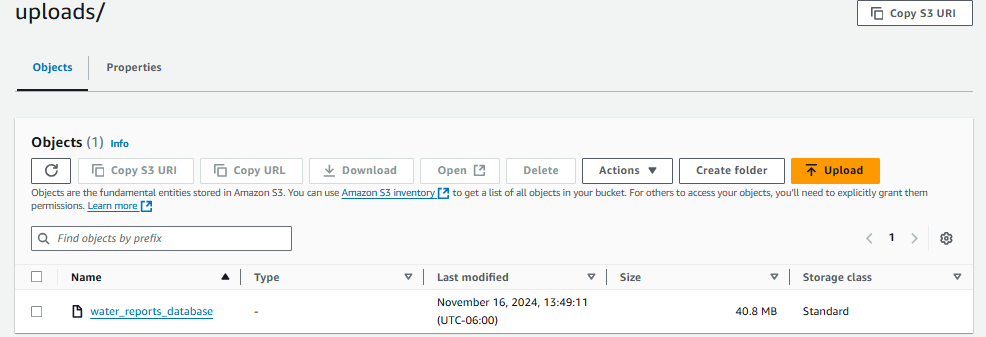